
# Analysis of the prediction results

The aim of this notebook is to retrieve which samples in the training data were wrongly classified.
For a subset of the mis-classfied results, it shows the inputs fed into the model and the models' output certainty,
so as to allow visualisation of the process and potentially pinpoint what caused the issue.

## Retrieval of misclassified samples

In [41]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from src.data_processing.MNIST import transform_to_trio_MNIST, prepare_for_model_training
from src.data_processing.number_extraction import extract_3_and_paste, extract_k_numbers
from src.models.max_mnist_predictor import MaxMNISTPredictor
from src.models.mnist_predictor import get_model
from src.evaluate_MNIST_models import train_model as train_model_MNIST
from src.evaluate_trio_mnist import train_model as train_model_trio_MNIST
from src.util.fileio import load_pkl_file, load_training_labels, show_image, load_model
from src.config import data_path, training_images_file, training_labels_file_name, retrain_models, models_path, \
    MNIST_PIXEL

analysis_model = "CNN"
analysis_dataset = "MNIST"

# here, train the model if not already trained
if not retrain_models:
    try:
        model = get_model(analysis_model, (MNIST_PIXEL, 3 * MNIST_PIXEL, 1) if analysis_dataset == "TRIO" else (MNIST_PIXEL, MNIST_PIXEL, 1))
        model_path = os.path.join(models_path, analysis_model + "_" + analysis_dataset + ".h5")
        load_model(model_path, model)
        model.summary()
    except:
        print("\tThe model file cannot be found at " + model_path + " so it will be retrained.")
        if analysis_dataset == "TRIO":
            model = train_model_trio_MNIST(analysis_model, generate_results=False)
        else:
            model = train_model_MNIST(analysis_model, analysis_dataset)
else:
    if analysis_dataset == "TRIO":
        model = train_model_trio_MNIST(analysis_model, generate_results=False)
    else:
        model = train_model_MNIST(analysis_model, analysis_dataset)

# Once model is found, predict on train data
training_images_file_path = os.path.join(data_path, training_images_file)
training_labels_file_path = os.path.join(data_path, training_labels_file_name)
x_train = load_pkl_file(training_images_file_path)
y_train = load_training_labels(training_labels_file_path)

# Predict output
print("\tPredicting data to model: " + analysis_model)
if analysis_dataset == "TRIO":
    x_train_trio = transform_to_trio_MNIST(x_train)
    x_train_trio = prepare_for_model_training(x_train_trio)
    y_predicted = model.predict(x_train_trio).argmax(axis=1)
else:
    y_predicted = MaxMNISTPredictor(model).predict_max_num(x_train)

# print the wrongly classified samples
df = pd.DataFrame()
df["actual"] = y_train
df["predicted"] = y_predicted
incorrect = df[df["actual"] != df["predicted"]]
print("There is a total of " + str(incorrect.shape[0]) + " incorrect predictions")
print(incorrect)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_64 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_65 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_66 (Batc (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_28 (Dropout)         (None, 12, 12, 32)        0         
__________

In [42]:
def plot_bar_pred_score(values):
    # this is for plotting purpose
    index = np.arange(10)
    plt.bar(index, values)
    plt.xlabel('Classification', fontsize=5)
    plt.ylabel('Percentage score', fontsize=5)
    plt.xticks(index, range(10), fontsize=5, rotation=30)
    plt.title('Classification score')
    plt.show()

## Subset analysis

Now, from the gathered predictions, print the original images of the first N wrongly classified samples.
Also, depending on which model was chosen, print the processed image that was fed to the model.

From the gathered predictions, show the model's evaluation on all classifications of of the first N wrongly classified samples.

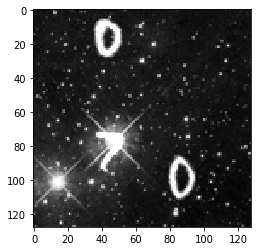

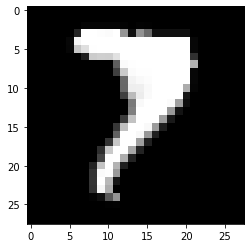

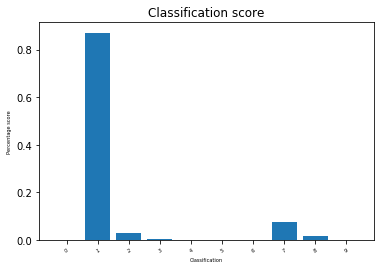

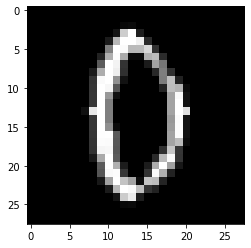

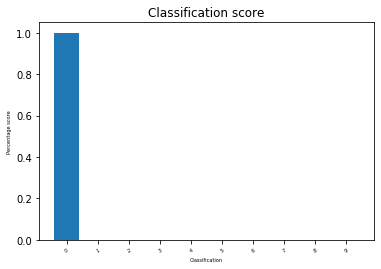

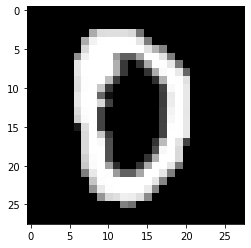

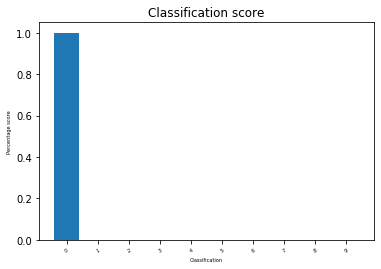

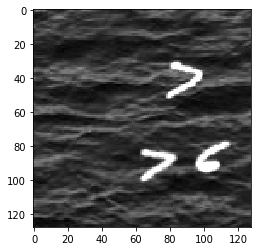

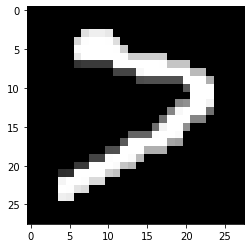

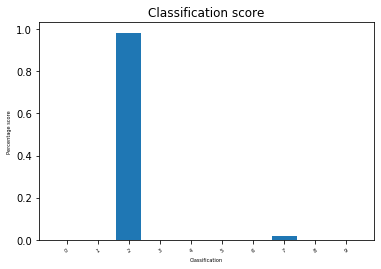

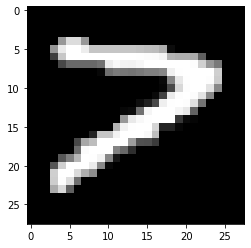

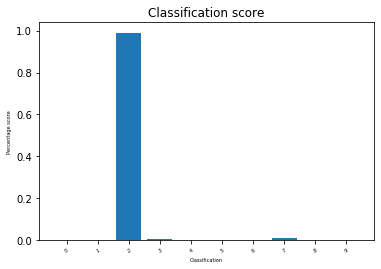

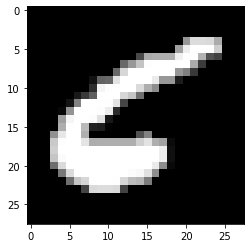

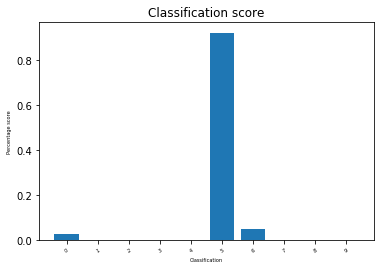

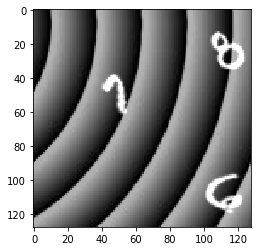

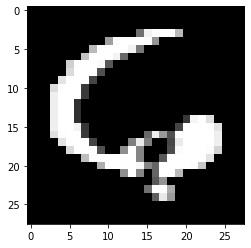

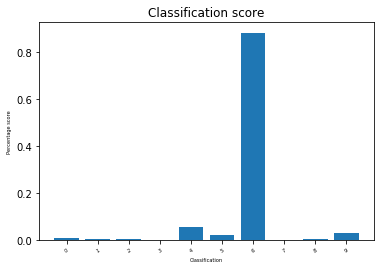

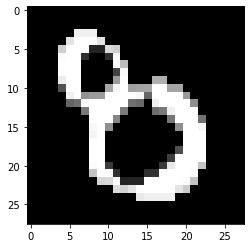

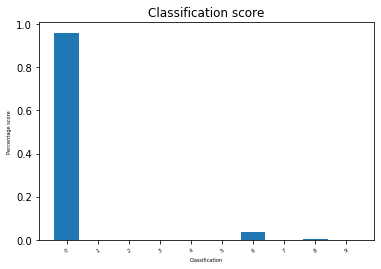

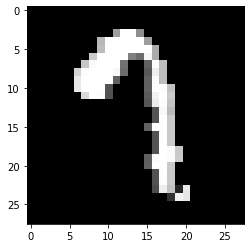

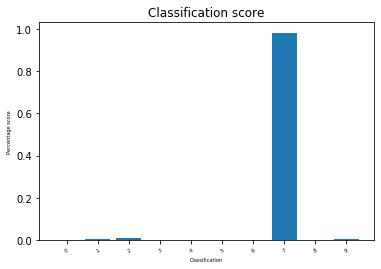

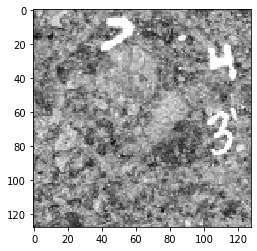

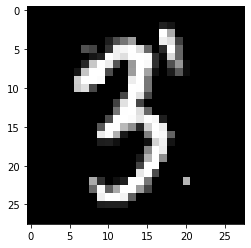

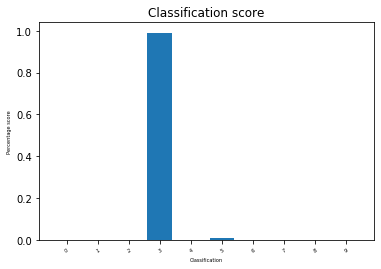

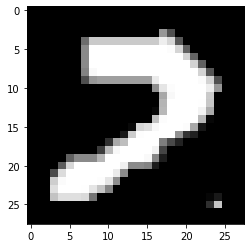

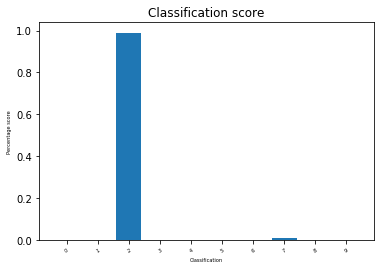

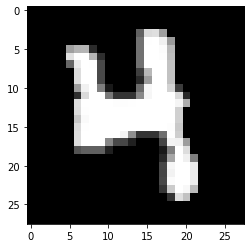

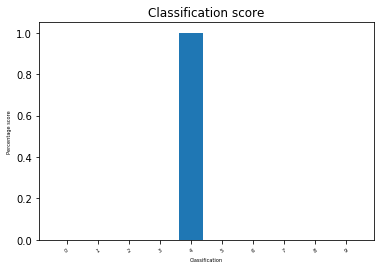

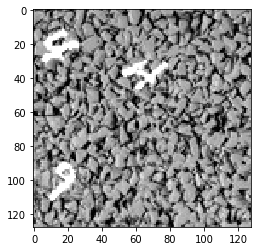

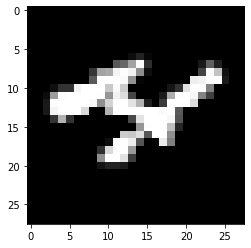

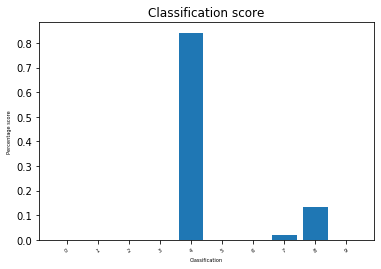

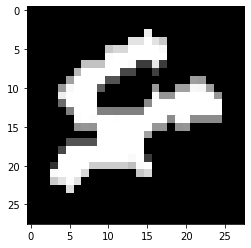

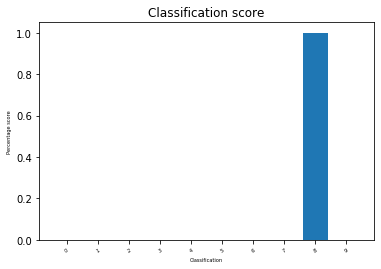

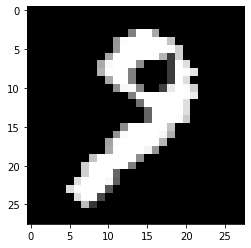

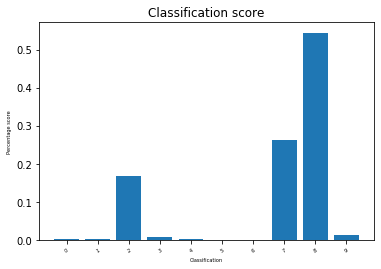

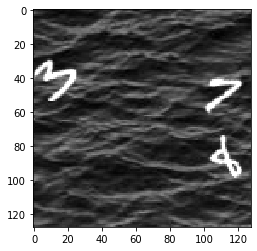

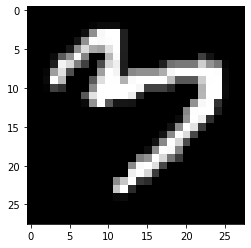

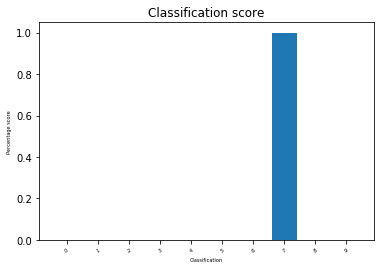

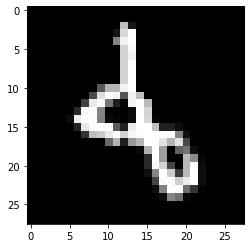

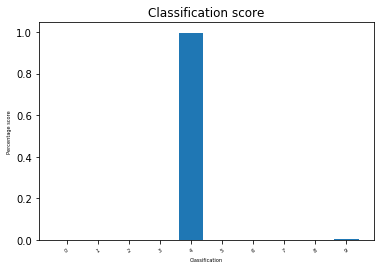

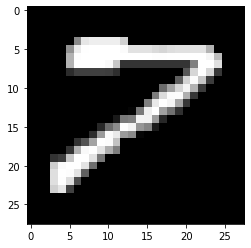

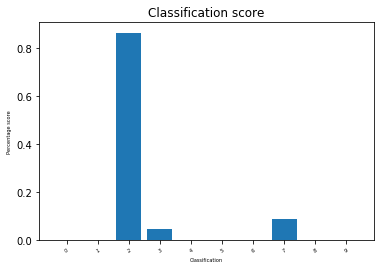

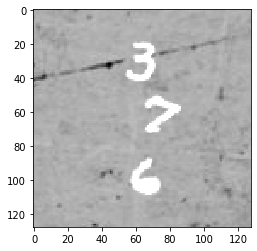

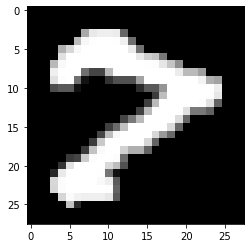

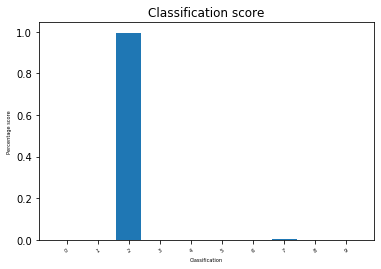

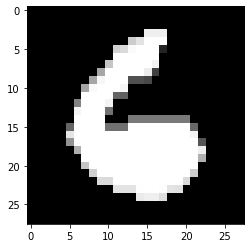

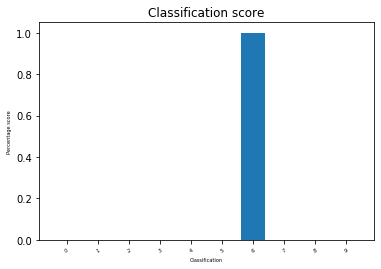

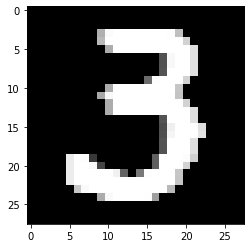

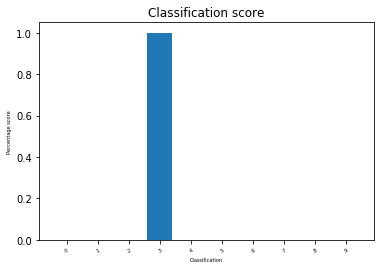

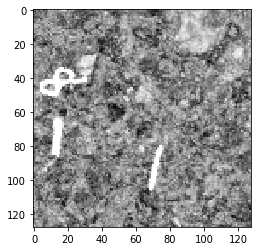

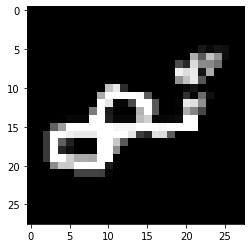

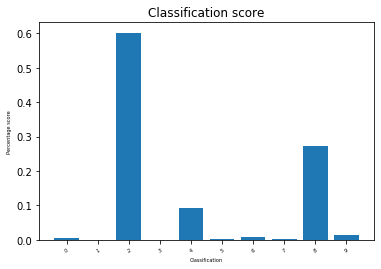

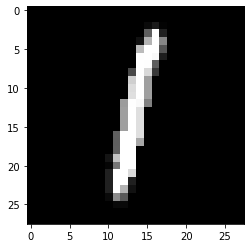

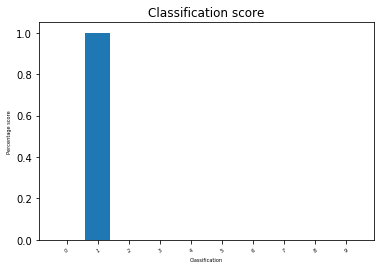

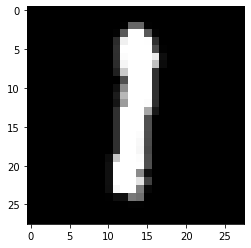

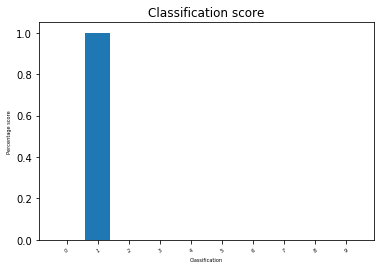

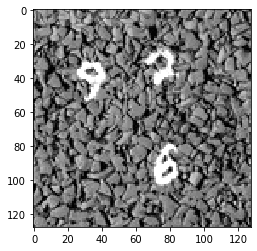

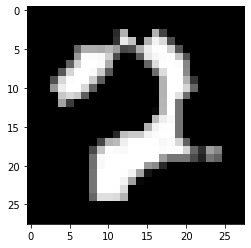

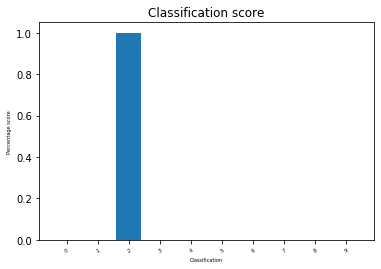

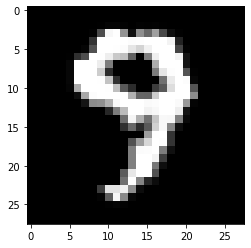

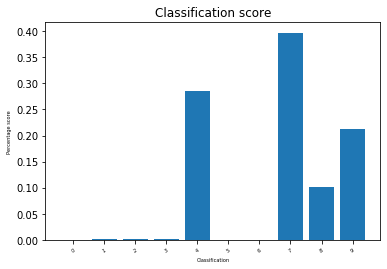

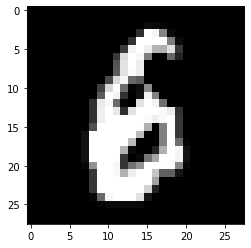

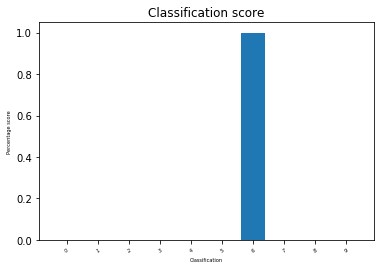

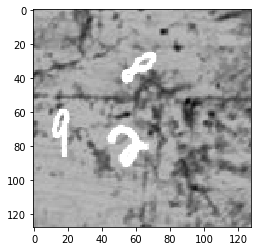

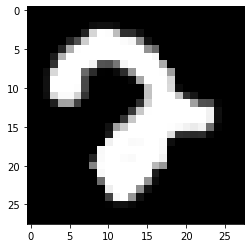

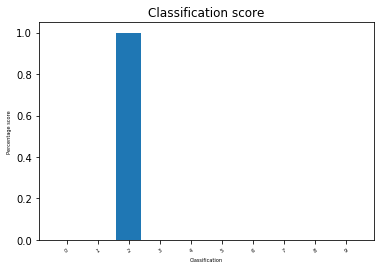

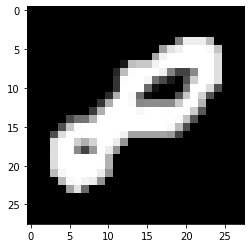

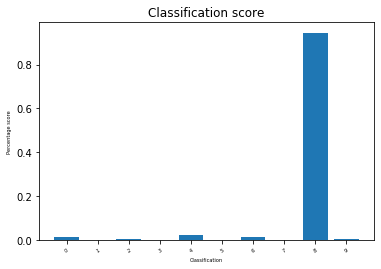

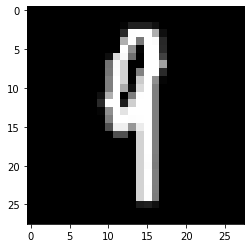

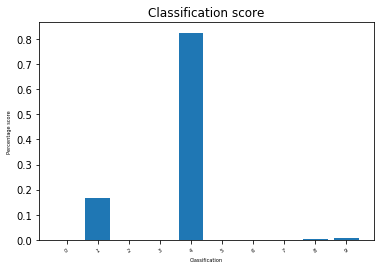

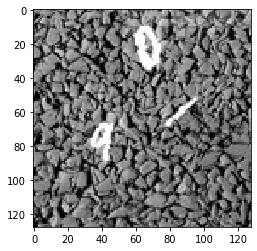

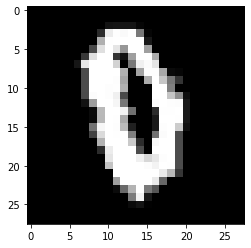

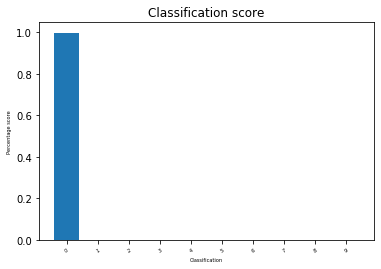

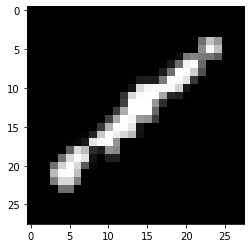

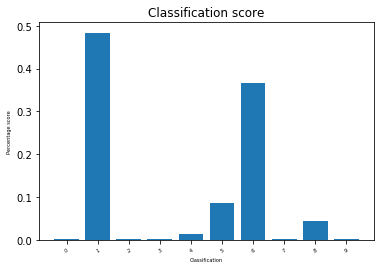

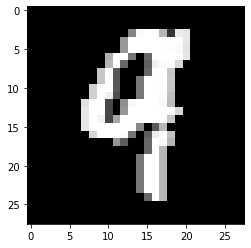

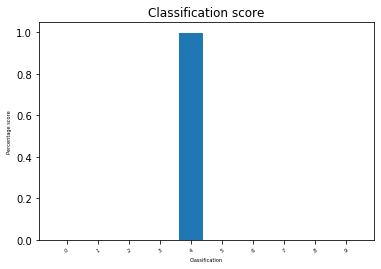

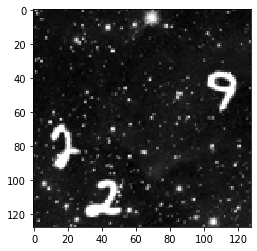

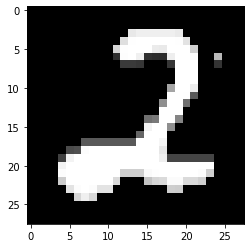

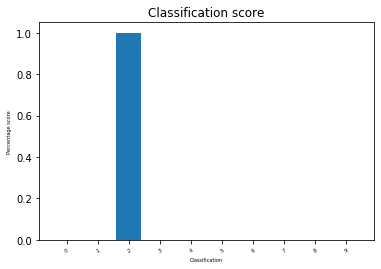

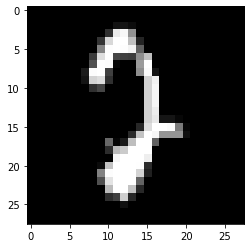

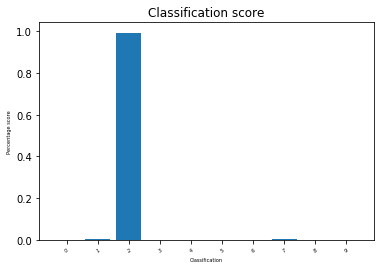

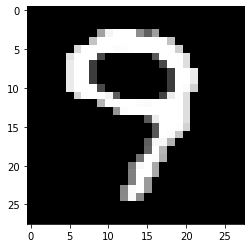

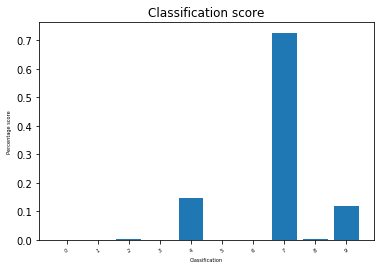

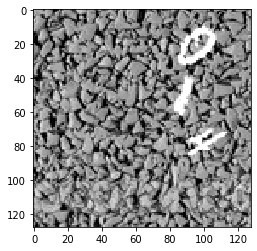

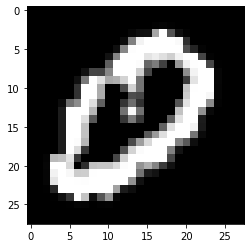

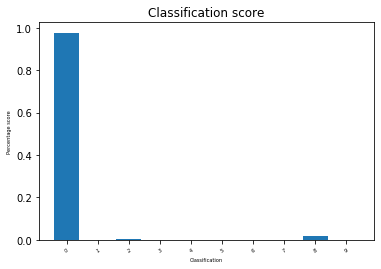

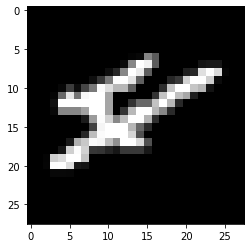

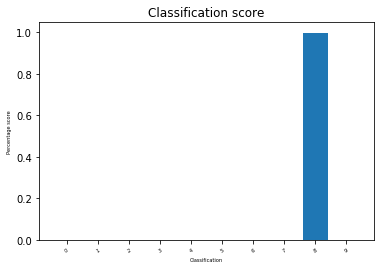

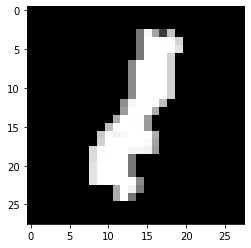

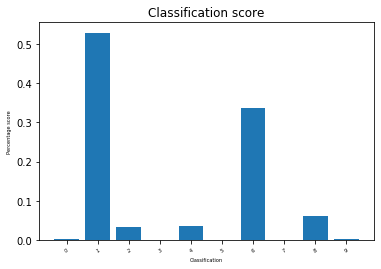

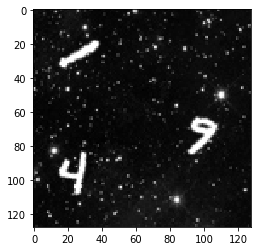

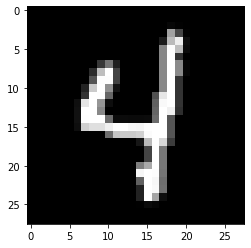

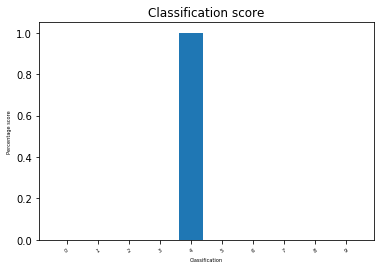

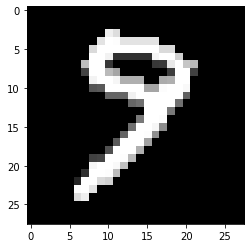

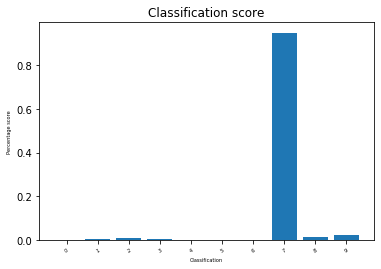

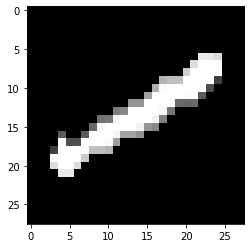

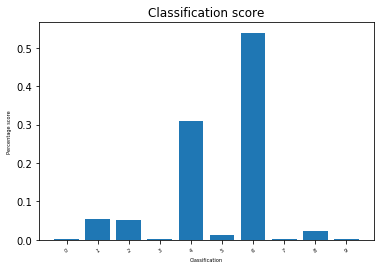

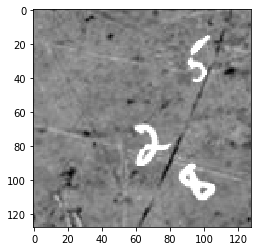

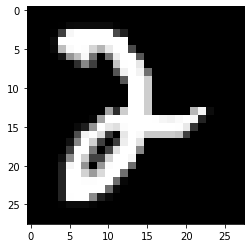

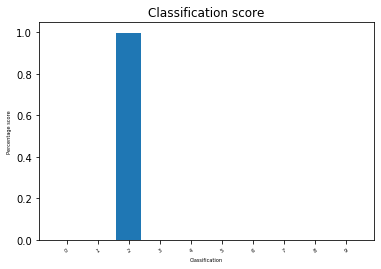

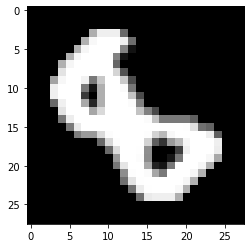

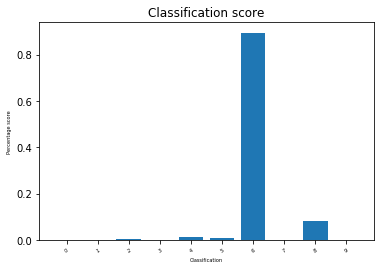

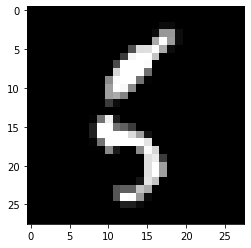

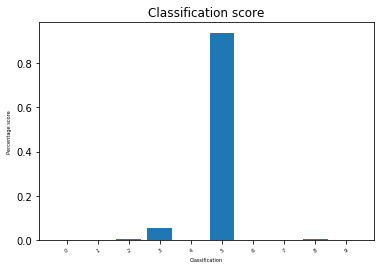

In [43]:
NB_ERRORS = 15
subset_incorrect = incorrect.head(NB_ERRORS)

if analysis_dataset == "MNIST":
    # print the 3 unique images
    for sample_id in subset_incorrect.index:
        # print the original image
        image = x_train[sample_id]
        show_image(image)
        
        # print the extracted numbers image and their pred score
        extracted_numbers = extract_k_numbers(image)
        for extracted_nb in extracted_numbers:
            show_image(extracted_nb)
            extracted_nb = prepare_for_model_training(extracted_nb)
            extracted_prediction_score = model.predict_proba(extracted_nb[np.newaxis, ...])
            plot_bar_pred_score(extracted_prediction_score[0])# TODO: should print a graph of predictions

elif analysis_dataset == "TRIO":
    for sample_id in subset_incorrect.index:
        # print the original image
        image = x_train[sample_id]
        show_image(image)
        
        # print the combined images
        trio = extract_3_and_paste(image, get_permutations = False)
        show_image(trio)
        
        # get the prediction score for the given sample
        trio = prepare_for_model_training(trio)
        prediction_score = model.predict_proba(trio[np.newaxis, ...])
        plot_bar_pred_score(prediction_score[0])